## Baseline

## Data Prep

In [1]:
#imports
import torch
import torchvision #PyTorch models, datasets, transofmrations etc
import torchvision.transforms as transforms

In [2]:
#Download Train And Test Data
train_data = torchvision.datasets.MNIST(root = "./MNIST_train", download = True, train = True, transform = transforms.ToTensor())
test_data = torchvision.datasets.MNIST(root = "./MNIST_test", download = True, train = False, transform = transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST_train/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_train/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST_train/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_train/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST_train/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_train/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST_train/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_train/MNIST/raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST_test/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_test/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST_test/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_test/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST_test/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_test/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST_test/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_test/MNIST/raw



In [5]:
#Startified Split Of Train Data Into Training and Validataion Sets

#The following thread was referred to for writing the code in this cell
#https://discuss.pytorch.org/t/how-to-do-a-stratified-split/62290

from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import SubsetRandomSampler, DataLoader

#Get The Train Data Targets Array
labels = train_data.targets
#Get The Splitting Indices - use 80-20 split again.
train_ind, val_ind = train_test_split(np.arange(len(labels)), test_size = 0.2, shuffle = True, stratify = labels)

tr_sampler = SubsetRandomSampler(train_ind)
val_sampler = SubsetRandomSampler(val_ind)

#Define Batch Size For Mini Batch Gradient Descent
batch_size = 64

#Create Data Loaders For Training And Validation Set
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=tr_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=val_sampler)


In [6]:
#Create Data Loaders For Test Set
test_loader = DataLoader(test_data, batch_size=batch_size)

## Modelling

In [9]:
#Define Model Architecture
import torch.nn as nn

# The following sources were referred to for writing the code in the below cells
# https://androidkt.com/initialize-weight-bias-pytorch/

# https://wandb.ai/authors/ayusht/reports/Implementing-Dropout-in-PyTorch-With-Example--VmlldzoxNTgwOTE

class BaselineCnn(nn.Module):
  def __init__(self):
    super(BaselineCnn, self).__init__()

    #Define Layers
    self.conv1 = nn.Conv2d(1,12,8)
    self.conv2 = nn.Conv2d(12,12,4)
    self.lin1 = nn.Linear(3888,30)
    self.lin2 = nn.Linear(30, 10)

    nn.init.xavier_uniform(self.conv1.weight)
    nn.init.xavier_uniform(self.conv2.weight)
    nn.init.xavier_uniform(self.lin1.weight)
    nn.init.xavier_uniform(self.lin2.weight)

    #Add Convolutional Layers
    self.cnn_layers = nn.Sequential(
        self.conv1,
        nn.ReLU(),
        self.conv2,
        nn.ReLU()
    )

    #Add Fully Connected Layers
    self.fc_layers = nn.Sequential(
        self.lin1,
        nn.ReLU(),
        self.lin2
    )

  

  #Define Forward Path
  def forward(self, x):
    x = self.cnn_layers(x)
    # print(x.shape)
    x = x.view(x.size(0), -1)
    # print(x.shape)
    x = self.fc_layers(x)
    # print(x.shape)

    return x



# RMSProp

In [16]:
model = BaselineCnn()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [17]:
#Create Function To Evaluate The Trained Model when given a dataloader and a model
def evall(dl, model):  
    tot = 0
    corr = 0
    # for data in dataloader:
    for batch in dl:
        ip, op = batch
        preds = model(ip)
        #Get The Class With The Maximum Output Value
        v, pred = torch.max(preds.data, 1)
        #Increment The Number Of Samples Tested Against
        tot += op.size(0)
        #Increment The Number Of Correctly Classified Samples
        corr += (pred == op).sum().item()

    acc = 100 * corr / tot
    print('Accuracy:', acc, '%')
    return acc

## Training

In [20]:
#Define The Loss Function, Training Optimizer and The Learning Rate Scheduler

# https://discuss.pytorch.org/t/performing-mini-batch-gradient-descent-or-stochastic-gradient-descent-on-a-mini-batch/21235/5
# help(optim.SGD)

# https://stackoverflow.com/questions/60050586/pytorch-change-the-learning-rate-based-on-number-of-epochs

import torch.optim as optim

#Define Start Leanring Rate and Momentum

# start_lr = 0.05
start_lr = 0.0001
momentum = 0.9

loss_function = nn.CrossEntropyLoss()
opti = optim.RMSprop(model.parameters(), lr = start_lr, momentum = momentum)

#create the learning rate scheduler to change lr to 10% of lr every 10 epochs
lrscheduler = optim.lr_scheduler.StepLR(opti, step_size=10, gamma = 0.1)

In [21]:
#Train on GPU
dev = "cuda:0" if torch.cuda.is_available() else "cpu"
td = torch.device(dev)
print(td)

cuda:0


In [22]:
tbs = int(60000*0.8)
vbs = int(60000*0.2)
tdl = DataLoader(train_data, batch_size=tbs, sampler=tr_sampler)
vdl = torch.utils.data.DataLoader(train_data, batch_size=vbs, sampler=val_sampler)


epoch_tr_losses = []
epoch_val_losses = []
epoch_val_accs = []
epoch_tr_accs = []
max_epochs = 20

#Define Early Stopping Patience - here 2 epochs
es_patience_count = 3
es_count = 0


for epoch in range(max_epochs):

    # for ind, data in enumerate(train_loader):
    for data in train_loader:

        ip, op = data

        opti.zero_grad()

        preds = model(ip)

        loss = loss_function(preds, op)
        loss.backward()
        opti.step()
        
    lrscheduler.step()

    for td in tdl:
      tr_ip, tr_op = td
      tr_preds = model(tr_ip)
      lt = loss_function(tr_preds, tr_op)
      epoch_tr_losses.append(lt.item())

    for vd in vdl:
      val_ip, val_op = vd
      val_preds = model(val_ip)
      lt = loss_function(val_preds, val_op)
      epoch_val_losses.append(lt.item())
        
    if epoch % 10 == 0:
      print(f"Epoch Number: {epoch} lr: {opti.param_groups[0]['lr']}")

    val_acc = evall(valid_loader, model)
    tr_acc = evall(train_loader, model)

    epoch_val_accs.append(val_acc)
    epoch_tr_accs.append(tr_acc)

    #Early Stopping based on vaidation acc

    if epoch == 0:
      best_loss = epoch_val_losses[0]
    print(epoch_val_losses[epoch] , best_loss)

    if epoch_val_losses[epoch] < best_loss:
      best_loss = epoch_val_losses[epoch]
      #save current model
      torch.save(model, 'best_model.pth')
    else:
      es_count += 1

    print(f"Epoch Number: {epoch}/{max_epochs}, Validation Accuracy: {val_acc}, Train Accuracy: {tr_acc}, Training Loss: {epoch_tr_losses[epoch]}, Validation Loss: {epoch_val_losses[epoch]}, Learning Rate: {opti.param_groups[0]['lr']}")

    #Implement Early Stopping
    if es_count > es_patience_count:
      print(f'Early Stopping Implemented at epoch {epoch}')
      break

Epoch Number: 0 lr: 0.0001
Accuracy: 97.8 %
Accuracy: 98.05416666666666 %
0.0712146982550621 0.0712146982550621
Epoch Number: 0/20, Validation Accuracy: 97.8, Train Accuracy: 98.05416666666666, Training Loss: 0.06227435916662216, Validation Loss: 0.0712146982550621, Learning Rate: 0.0001
Accuracy: 97.95 %
Accuracy: 98.7375 %
0.061713945120573044 0.0712146982550621
Epoch Number: 1/20, Validation Accuracy: 97.95, Train Accuracy: 98.7375, Training Loss: 0.04173460230231285, Validation Loss: 0.061713945120573044, Learning Rate: 0.0001
Accuracy: 98.38333333333334 %
Accuracy: 99.05 %
0.05227796360850334 0.061713945120573044
Epoch Number: 2/20, Validation Accuracy: 98.38333333333334, Train Accuracy: 99.05, Training Loss: 0.031498562544584274, Validation Loss: 0.05227796360850334, Learning Rate: 0.0001
Accuracy: 98.25833333333334 %
Accuracy: 99.22916666666667 %
0.05110807716846466 0.05227796360850334
Epoch Number: 3/20, Validation Accuracy: 98.25833333333334, Train Accuracy: 99.22916666666667,

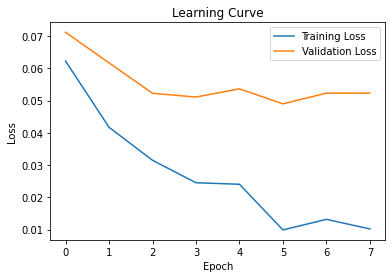

In [23]:
#Plot Learning Curves
import matplotlib.pyplot as plt
plt.plot(epoch_tr_losses, label = 'Training Loss')
plt.plot(epoch_val_losses, label = 'Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
evall(test_loader, model)

Accuracy: 98.69 %


98.69

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def cal_confusion_matrix(dl, model):
    preds = torch.empty((0))
    labels = torch.empty((0))
    for batch in dl:
        ip, op = batch
        pred = model(ip)
        v, pred = torch.max(pred.data, 1)
        preds = torch.cat((preds, pred))
        labels = torch.cat((labels, op))
    
    ConfusionMatrixDisplay.from_predictions(labels, preds)
    plt.show()




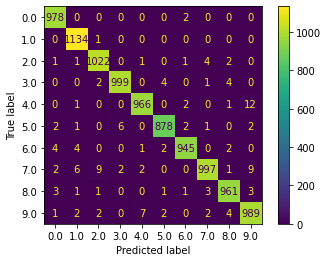

In [27]:
cal_confusion_matrix(test_loader, model)


# ADAM

In [28]:
model = BaselineCnn()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [29]:
#Create Function To Evaluate The Trained Model when given a dataloader and a model
def evall(dl, model):  
    tot = 0
    corr = 0
    # for data in dataloader:
    for batch in dl:
        ip, op = batch
        preds = model(ip)
        #Get The Class With The Maximum Output Value
        v, pred = torch.max(preds.data, 1)
        #Increment The Number Of Samples Tested Against
        tot += op.size(0)
        #Increment The Number Of Correctly Classified Samples
        corr += (pred == op).sum().item()

    acc = 100 * corr / tot
    print('Accuracy:', acc, '%')
    return acc

## Training

In [32]:
#Define The Loss Function, Training Optimizer and The Learning Rate Scheduler

# The following sources were referred to for writing the code in the below cells
# https://discuss.pytorch.org/t/performing-mini-batch-gradient-descent-or-stochastic-gradient-descent-on-a-mini-batch/21235/5
# help(optim.SGD)

# https://stackoverflow.com/questions/60050586/pytorch-change-the-learning-rate-based-on-number-of-epochs

import torch.optim as optim

#Define Start Leanring Rate and Momentum

# start_lr = 0.05
start_lr = 0.0001
momentum = 0.9

#Already Applies SoftMax???
loss_function = nn.CrossEntropyLoss()
opti = optim.Adam(model.parameters(), lr = start_lr)

#create the learning rate scheduler to change lr to 10% of lr every 10 epochs
lrscheduler = optim.lr_scheduler.StepLR(opti, step_size=10, gamma = 0.1)

In [33]:
#Train on GPU
dev = "cuda:0" if torch.cuda.is_available() else "cpu"
td = torch.device(dev)
print(td)

cuda:0


In [34]:
tbs = int(60000*0.8)
vbs = int(60000*0.2)
tdl = DataLoader(train_data, batch_size=tbs, sampler=tr_sampler)
vdl = torch.utils.data.DataLoader(train_data, batch_size=vbs, sampler=val_sampler)


epoch_tr_losses = []
epoch_val_losses = []
epoch_val_accs = []
epoch_tr_accs = []
max_epochs = 20

#Define Early Stopping Patience - here 2 epochs
es_patience_count = 3
es_count = 0


for epoch in range(max_epochs):

    # for ind, data in enumerate(train_loader):
    for data in train_loader:

        ip, op = data

        opti.zero_grad()

        preds = model(ip)

        loss = loss_function(preds, op)
        loss.backward()
        opti.step()
        
    lrscheduler.step()

    for td in tdl:
      tr_ip, tr_op = td
      tr_preds = model(tr_ip)
      lt = loss_function(tr_preds, tr_op)
      epoch_tr_losses.append(lt.item())

    for vd in vdl:
      val_ip, val_op = vd
      val_preds = model(val_ip)
      lt = loss_function(val_preds, val_op)
      epoch_val_losses.append(lt.item())
        
    if epoch % 10 == 0:
      print(f"Epoch Number: {epoch} lr: {opti.param_groups[0]['lr']}")

    val_acc = evall(valid_loader, model)
    tr_acc = evall(train_loader, model)

    epoch_val_accs.append(val_acc)
    epoch_tr_accs.append(tr_acc)

    #Early Stopping based on vaidation acc

    if epoch == 0:
      best_loss = epoch_val_losses[0]
    print(epoch_val_losses[epoch] , best_loss)

    if epoch_val_losses[epoch] < best_loss:
      best_loss = epoch_val_losses[epoch]
      #save current model
      torch.save(model, 'best_model.pth')
    else:
      es_count += 1

    print(f"Epoch Number: {epoch}/{max_epochs}, Validation Accuracy: {val_acc}, Train Accuracy: {tr_acc}, Training Loss: {epoch_tr_losses[epoch]}, Validation Loss: {epoch_val_losses[epoch]}, Learning Rate: {opti.param_groups[0]['lr']}")

    # "Implement Early Stopping"
    if es_count > es_patience_count:
      print(f'Early Stopping Implemented at epoch {epoch}')
      break

Epoch Number: 0 lr: 0.0001
Accuracy: 91.69166666666666 %
Accuracy: 92.16041666666666 %
0.2831994891166687 0.2831994891166687
Epoch Number: 0/20, Validation Accuracy: 91.69166666666666, Train Accuracy: 92.16041666666666, Training Loss: 0.2782903015613556, Validation Loss: 0.2831994891166687, Learning Rate: 0.0001
Accuracy: 94.45 %
Accuracy: 94.62291666666667 %
0.18577302992343903 0.2831994891166687
Epoch Number: 1/20, Validation Accuracy: 94.45, Train Accuracy: 94.62291666666667, Training Loss: 0.183745875954628, Validation Loss: 0.18577302992343903, Learning Rate: 0.0001
Accuracy: 95.875 %
Accuracy: 96.16458333333334 %
0.13899672031402588 0.18577302992343903
Epoch Number: 2/20, Validation Accuracy: 95.875, Train Accuracy: 96.16458333333334, Training Loss: 0.13524194061756134, Validation Loss: 0.13899672031402588, Learning Rate: 0.0001
Accuracy: 96.43333333333334 %
Accuracy: 96.67083333333333 %
0.1217149943113327 0.13899672031402588
Epoch Number: 3/20, Validation Accuracy: 96.4333333333

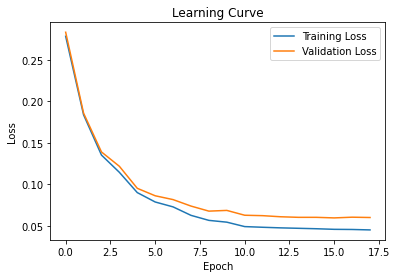

In [36]:
#Plot Learning Curves
import matplotlib.pyplot as plt
plt.plot(epoch_tr_losses, label = 'Training Loss')
plt.plot(epoch_val_losses, label = 'Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
evall(test_loader, model)

Accuracy: 98.44 %


98.44

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def cal_confusion_matrix(dl, model):
    preds = torch.empty((0))
    labels = torch.empty((0))
    for batch in dl:
        ip, op = batch
        pred = model(ip)
        v, pred = torch.max(pred.data, 1)
        preds = torch.cat((preds, pred))
        labels = torch.cat((labels, op))
    
    ConfusionMatrixDisplay.from_predictions(labels, preds)
    plt.show()

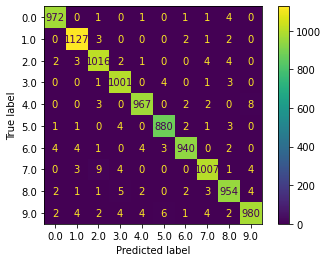

In [40]:
cal_confusion_matrix(test_loader, model)


# Nesterov

In [41]:
model = BaselineCnn()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [42]:
#Create Function To Evaluate The Trained Model when given a dataloader and a model
def evall(dl, model):  
    tot = 0
    corr = 0
    # for data in dataloader:
    for batch in dl:
        ip, op = batch
        preds = model(ip)
        #Get The Class With The Maximum Output Value
        v, pred = torch.max(preds.data, 1)
        #Increment The Number Of Samples Tested Against
        tot += op.size(0)
        #Increment The Number Of Correctly Classified Samples
        corr += (pred == op).sum().item()

    acc = 100 * corr / tot
    print('Accuracy:', acc, '%')
    return acc

## Training

In [45]:
#Define The Loss Function, Training Optimizer and The Learning Rate Scheduler

# The following sources were referred to for writing the code in the below cells

# https://discuss.pytorch.org/t/performing-mini-batch-gradient-descent-or-stochastic-gradient-descent-on-a-mini-batch/21235/5

# https://stackoverflow.com/questions/60050586/pytorch-change-the-learning-rate-based-on-number-of-epochs

import torch.optim as optim

#Define Start Leanring Rate and Momentum

# start_lr = 0.05
start_lr = 0.0001
momentum = 0.9

#Already Applies SoftMax???
loss_function = nn.CrossEntropyLoss()
opti = optim.SGD(model.parameters(), lr = start_lr, momentum=momentum, nesterov=True)



#create the learning rate scheduler to change lr to 10% of lr every 10 epochs
lrscheduler = optim.lr_scheduler.StepLR(opti, step_size=10, gamma = 0.1)

In [46]:
#Train on GPU
dev = "cuda:0" if torch.cuda.is_available() else "cpu"
td = torch.device(dev)
print(td)

cuda:0


In [47]:
# loss_arr = []

tbs = int(60000*0.8)
vbs = int(60000*0.2)
tdl = DataLoader(train_data, batch_size=tbs, sampler=tr_sampler)
vdl = torch.utils.data.DataLoader(train_data, batch_size=vbs, sampler=val_sampler)


epoch_tr_losses = []
epoch_val_losses = []
epoch_val_accs = []
epoch_tr_accs = []
max_epochs = 20

#Define Early Stopping Patience - here 2 epochs
es_patience_count = 3
es_count = 0


for epoch in range(max_epochs):

    for data in train_loader:

        ip, op = data

        opti.zero_grad()

        preds = model(ip)

        loss = loss_function(preds, op)
        loss.backward()
        opti.step()
        
    lrscheduler.step()

    for td in tdl:
      tr_ip, tr_op = td
      tr_preds = model(tr_ip)
      lt = loss_function(tr_preds, tr_op)
      epoch_tr_losses.append(lt.item())

    for vd in vdl:
      val_ip, val_op = vd
      val_preds = model(val_ip)
      lt = loss_function(val_preds, val_op)
      epoch_val_losses.append(lt.item())
        
    if epoch % 10 == 0:
      print(f"Epoch Number: {epoch} lr: {opti.param_groups[0]['lr']}")

    val_acc = evall(valid_loader, model)
    tr_acc = evall(train_loader, model)

    epoch_val_accs.append(val_acc)
    epoch_tr_accs.append(tr_acc)

    #Early Stopping based on vaidation acc

    if epoch == 0:
      best_loss = epoch_val_losses[0]
    print(epoch_val_losses[epoch] , best_loss)

    if epoch_val_losses[epoch] < best_loss:
      best_loss = epoch_val_losses[epoch]
      #save current model
      torch.save(model, 'best_model.pth')
    else:
      es_count += 1

    print(f"Epoch Number: {epoch}/{max_epochs}, Validation Accuracy: {val_acc}, Train Accuracy: {tr_acc}, Training Loss: {epoch_tr_losses[epoch]}, Validation Loss: {epoch_val_losses[epoch]}, Learning Rate: {opti.param_groups[0]['lr']}")

    # "Implement Early Stopping"
    if es_count > es_patience_count:
      print(f'Early Stopping Implemented at epoch {epoch}')
      break

Epoch Number: 0 lr: 0.0001
Accuracy: 67.45 %
Accuracy: 66.50208333333333 %
1.585263967514038 1.585263967514038
Epoch Number: 0/20, Validation Accuracy: 67.45, Train Accuracy: 66.50208333333333, Training Loss: 1.5914931297302246, Validation Loss: 1.585263967514038, Learning Rate: 0.0001
Accuracy: 86.49166666666666 %
Accuracy: 86.71875 %
0.470956414937973 1.585263967514038
Epoch Number: 1/20, Validation Accuracy: 86.49166666666666, Train Accuracy: 86.71875, Training Loss: 0.4757365584373474, Validation Loss: 0.470956414937973, Learning Rate: 0.0001
Accuracy: 89.05833333333334 %
Accuracy: 89.0375 %
0.37953686714172363 0.470956414937973
Epoch Number: 2/20, Validation Accuracy: 89.05833333333334, Train Accuracy: 89.0375, Training Loss: 0.38091784715652466, Validation Loss: 0.37953686714172363, Learning Rate: 0.0001
Accuracy: 90.30833333333334 %
Accuracy: 90.26458333333333 %
0.3404741883277893 0.37953686714172363
Epoch Number: 3/20, Validation Accuracy: 90.30833333333334, Train Accuracy: 90.

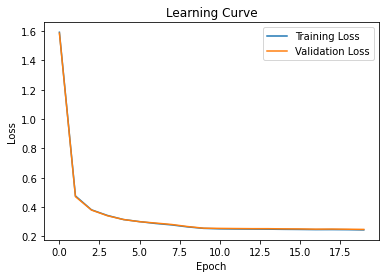

In [49]:
#Plot Learning Curves
import matplotlib.pyplot as plt
plt.plot(epoch_tr_losses, label = 'Training Loss')
plt.plot(epoch_val_losses, label = 'Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
evall(test_loader, model)

Accuracy: 93.21 %


93.21

In [52]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def cal_confusion_matrix(dl, model):
    preds = torch.empty((0))
    labels = torch.empty((0))
    for batch in dl:
        ip, op = batch
        pred = model(ip)
        v, pred = torch.max(pred.data, 1)
        preds = torch.cat((preds, pred))
        labels = torch.cat((labels, op))
    
    ConfusionMatrixDisplay.from_predictions(labels, preds)
    plt.show()

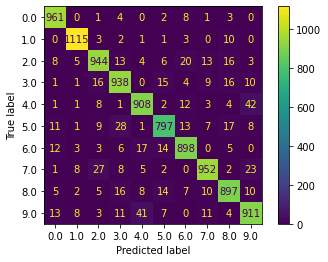

In [53]:
cal_confusion_matrix(test_loader, model)


## Results Discussion

We can notice that using RMSProp facilitates in pretty fast learning with the model achieving a test accuracy of 98.69% after around 7 epochs. Using ADAM we can see that the training is slower but also more stable and smooth, with the model reaching an accuracy of 98.4% after around 17 epochs. Using the Nesterov optimizer in SGD has the most interesting results with the model converging very quickly initially but then slows down and plateaus at a test accuracy of 93% after around 17 epochs. Therefore RMSProp seems to be the best optimizer in this case as it gives the best results in the shortest time.

# References

Therefore the following sources were referred to for this assignment (Mentioning all the sources at one place again):

- https://pytorch.org/docs/stable/index.html

- https://scikit-learn.org/0.21/documentation.html

- https://discuss.pytorch.org/t/how-to-do-a-stratified-split/62290

- https://github.com/satyajitghana/PadhAI-Course/blob/master/colab-notebooks/16_PyTorchCNN.ipynb

- https://androidkt.com/initialize-weight-bias-pytorch/

- https://wandb.ai/authors/ayusht/reports/Implementing-Dropout-in-PyTorch-With-Example--VmlldzoxNTgwOTE

- https://discuss.pytorch.org/t/performing-mini-batch-gradient-descent-or-stochastic-gradient-descent-on-a-mini-batch/21235/5

- https://stackoverflow.com/questions/60050586/pytorch-change-the-learning-rate-based-on-number-of-epochs



